In [21]:
import wandb
import numpy as np
import pandas as pd

from svm_proxy import *
from sklearn.metrics import accuracy_score

In [22]:
class test_proxy:

    def __init__(self, proxy, attacker, X_val, y_val, log):
        """
        inputs   : proxy = incremental model object
                   attacker = attacker object
                   X_valid, y_valid = dataset for accuracy metric
                   log = whether to log in wandb
        """
        self.log = log
        self.run = None
        self.proxy = proxy
        self.attacker = attacker
        self.proxy_acc = None
        self.attacker_acc = None

        # stored dataset
        self.X_val, self.y_val = X_val, y_val

        if log:
            self.run = wandb.init('model_security')

    def steal(self, max_queries): 

        for query in range(max_queries):

            x, y = attacker.query_fit() # query and improve fit; return the query point and accuracy
            self.attacker_acc = accuracy_score(self.attacker.predict(self.X_val), self.y_val)

            proxy.update(x, y)
            self.proxy_acc = accuracy_score(self.proxy.predict(self.X_val), self.y_val)

            if self.log:
                wandb.log({
                    "proxy_acc" : self.proxy_acc,
                    "attacker_acc" : self.attacker_acc,
                    'acc_diff': self.proxy_acc - self.attacker_acc
                })

        self.run.finish()
                

## Naive testing

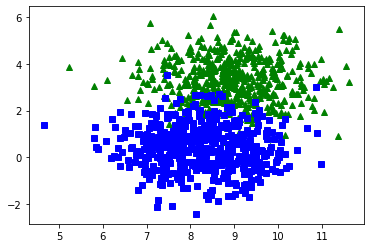

SVC(kernel='linear')

In [23]:
from sklearn import datasets
from sklearn.svm import SVC

X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 6)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

clf = SVC(kernel = 'linear')
clf.fit(X, y)

In [24]:
import random
class naive_attacker:
    def __init__(self, target, x1_range = (0, 10), x2_range = (-3, 8)):
        self.x1_range, self.x2_range = x1_range, x2_range
        self.target = target
        self.clf = SVC()
        
        self.started = False

        # store queries
        self.X = None
        self.Y = []

    def query_fit(self):
        x1 = random.randint(self.x1_range[0], self.x1_range[1])
        x2 = random.randint(self.x2_range[0], self.x2_range[1])
        x = np.array([x1, x2])

        if not isinstance(self.X, np.ndarray):
            self.X = np.expand_dims(x, axis = 0)
        else:
            self.X = np.vstack((self.X, x))
        
        if x.ndim == 1:
            x = np.expand_dims(x, axis = 0)

        y = self.target.predict(x)
        self.Y.append(y)

        if not self.started:
            if (1 in self.Y) and (0 in self.Y):
                self.started = True
        
        if self.started:
            self.clf.fit(self.X, self.Y)

        return x, y

    def predict(self, X):

        if self.started:
            return self.clf.predict(X)
        else:
            return [random.choice([0, 1]) for __ in range(len(X))]



In [27]:
proxy = online_lssvm()
# proxy = online_svm_sgd() # has issues with fit with 1 class
attacker = naive_attacker(clf)
naive_test = test_proxy(proxy, attacker, X, y, log = True)
naive_test.steal(100)

proxy_acc,0.934
attacker_acc,0.93
acc_diff,0.004
_step,99
_runtime,3
_timestamp,1605843200


proxy_acc,▁███▇▇▇▇████████████████████████████████
attacker_acc,▁▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
acc_diff,▁▅█▅▅▃▃▄▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
